In [35]:
import planetspy as ps
import planetspy.engines as eng
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

class record:
    loc = []
    def __init__(self, bodies):
        self.loc.append(np.copy(bodies[0][::,0:3]))
    def run(self, simclass):
        self.loc.append(np.copy(simclass.bodies[0][::,0:3]))
        return False

bodies = [
    np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.371*10**6, 5.972*10**24],
              [0, 6.371*10**6 + 400*10**3, 0, -7667, 0, 0, 1, 1000],
              [6.371*10**6 + 385*10**6, 0, 0, 0, 10**3, 0, 1737.5*10**3, 7.35*10**22]
             ])
    , [["Earth", "r-"], ["ISS", "b-"],["Moon", "m-"]]
]

recinst = record(bodies)
sim = ps.Simulate(eng.PP, 1, 10, bodies, bailout = 60*60*24*31, envmod=[recinst])
sim.main_loop()
sim.steps

267840.0

In [10]:
print(len(bodies))

2


<IPython.core.display.Javascript object>


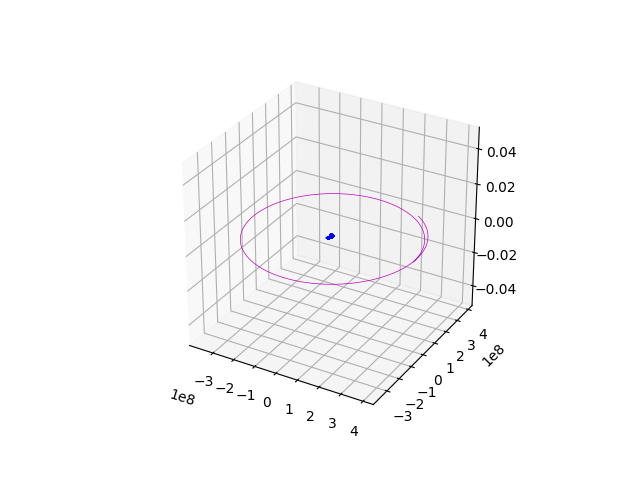

In [36]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(0,len(bodies)+1):
    ax.plot([i[j][0] for i in recinst.loc], [i[j][1] for i in recinst.loc], [i[j][2] for i in recinst.loc], bodies[1][j][1], linewidth = .5)

#patches = [Sphere(bodies[0][i][:3], bodies[0][i,6]) for i in range(0,len(bodies)+1)]
#plt.xlim(0, 6.371*10**6 + 400*10**3)
#plt.ylim(0, 6.371*10**6 + 400*10**3)
ax.set_aspect("equal")
#patches
#ax.add_collection(PatchCollection(patches, alpha=0.4))
plt.show()

In [ ]:
#animation 



[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          6.37100000e+06,  5.97200000e+24],
        [-1.80789895e+07,  1.03515295e+07,  1.07828432e+05,
         -3.04729103e+03, -1.85092939e+03, -1.92805145e+01,
          1.00000000e+05,  0.00000000e+00]]), [['Earth'], ['ISS']]]